In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import pandas as pd
import math
import scipy as sp
from scipy.optimize import curve_fit

import skimage
import skimage.io
from skimage.morphology import disk
from skimage.filters import rank

plt.style.use('styleNB.mplstyle')

import cv2
from scipy.ndimage import gaussian_filter, binary_dilation
from skimage.measure import regionprops, label
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter


######################################
######################################
# Functions for segmentation
######################################
######################################

def generate_gradient_mask(image, threshold=50):
    """
    Generates a binary mask based on the gradient magnitude.

    Parameters:
        image (np.ndarray): The input 2D image.
        threshold (int): The threshold value for gradient magnitude.

    Returns:
        np.ndarray: The binary mask.
    """
    # Convert image to grayscale
    image = image.astype(np.float32)

    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold the gradient magnitude to generate the mask
    mask = (gradient_magnitude > threshold).astype(np.uint8)

    return mask

def smooth_mask_edges(mask, sigma=1.0, threshold=0.5):
    """
    Smooth the edges of a binary mask using Gaussian blurring and return a binary mask.
    
    Parameters:
    mask (np.ndarray): The input binary mask image.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    threshold (float): The threshold to convert the smoothed mask back to binary.
    
    Returns:
    np.ndarray: The smoothed binary mask image.
    """
    # Ensure the mask is binary (0 or 1)
    binary_mask = mask.astype(np.int32)
    
    # Apply Gaussian filter for smoothing
    smoothed_mask = gaussian_filter(binary_mask, sigma=sigma)
    
    # Normalize the smoothed mask to the range [0, 1]
    smoothed_mask = (smoothed_mask - smoothed_mask.min()) / (smoothed_mask.max() - smoothed_mask.min())
    
    # Apply threshold to convert back to binary mask
    smoothed_binary_mask = (smoothed_mask > threshold).astype(np.int32)
    
    # Dilate the mask to ensure it doesn't shrink
    dilated_mask = binary_dilation(smoothed_binary_mask, iterations=int(sigma))
    
    
    return dilated_mask
    
######################################
######################################
# Functions for intensity determination
######################################
######################################
from shapely.geometry import LineString
from shapely.ops import unary_union
from skimage import measure

def mask_to_polygon(mask):
    """Converts a pixel mask into a line that outlines the edge."""
    # Find contours in the mask
    contours = measure.find_contours(mask, 0.5)

    # Select the longest contour
    contour = max(contours, key=len)

    # Convert the contour points to integer coordinates
    contour = np.round(contour).astype(int)

    # Filter out duplicate points from the contour
    unique_contour = []
    for point in contour:
        if len(unique_contour) == 0 or not np.array_equal(unique_contour[-1], point):
            unique_contour.append(point)

    return unique_contour

def polygon_to_line(mask):
    # Convert mask to polygon
    line = mask_to_polygon(mask)
    line = LineString(line)

    # Find the centroid of the polygon
    centroid = line.centroid

    # Find the southmost point relative to the centroid (maximum y-coordinate)
    max_y = max(line.coords, key=lambda point: point[1])

    # Rotate the line so that the southmost point is the first point
    coords = list(line.coords)
    max_y_index = coords.index(max_y)
    rotated_coords = coords[max_y_index:] + coords[:max_y_index]

    line = LineString(rotated_coords)

    # Redraw line with equally spaced coords
    n = 301
    distances = np.linspace(0, line.length, n)
    points = [line.interpolate(distance) for distance in distances]
    new_line = LineString(points)
   
    return new_line

def cell_contour_intensity_max(new_line, im):
    vals = []

    for j in np.arange(300):
        a = list(new_line.coords)[j]
        b = list(new_line.coords)[j + 1]
        cd_length = 20 

        ab = LineString([a, b])
        left = ab.parallel_offset(cd_length * 0.5, 'left')
        right = ab.parallel_offset(cd_length * 0.5, 'right')
        c = left.boundary.bounds[-2:]
        d = right.boundary.bounds[:2]  # note the different orientation for right offset

        cd = LineString([c, d])

        # Generate line mask
        n = 100
        distances_ = np.linspace(0, cd.length, n)
        points_ = [cd.interpolate(distance) for distance in distances_]
        mask = np.zeros(im.shape)
        for k in np.arange(len(points_)):
            mask[int(list(points_[k].coords)[0][1]), int(list(points_[k].coords)[0][0])] = 1

        # Background subtract
        im = im - np.mean(im[:10, :10])
        vals_ = np.max(np.multiply(mask, im))
        vals = np.append(vals, vals_)
    
    return vals


######################################
######################################
# Functions for fitting
######################################
######################################

def linear(t, a, b):
    # S**2 = S2_ + 4Dt
    # b = 4D
    return a + b*t



## Quantification of D 

In [8]:
im_dir = glob.glob('../../data/microscopy/Amy/*/*/20240213_GalvGFP_1.2mA_10*.tif')
f = im_dir[0]

# load image (I'm using the original image file)
img = AICSImage(f)  
im = img.get_image_data("TCZYX") 
im_ = im[:,0,0,:,:] # select phase image

im_mask = np.zeros_like(im_)

for i in np.arange(im_.shape[0]):
    # gradient of phase image, with threshold cutoff to identify cell boundaries 
    im_temp = generate_gradient_mask(im_[i,:,:], threshold=600)

    # dilate to connect any discontinuities and fill holes
    bw = sp.ndimage.binary_dilation(im_temp, structure = np.ones((1,1)), iterations=1)
    bw = sp.ndimage.binary_fill_holes(bw)

    # erode a bit to shrink masks
    bw_mask = sp.ndimage.binary_erosion(bw, structure = np.ones((3,3)), iterations=2)

    im_mask[i,:,:] = smooth_mask_edges(bw_mask, sigma=1.0)
    

In [9]:
# Load in galvanin data
im_dir = glob.glob('../../data/microscopy/Amy/*/*/20240213_GalvGFP_1.2mA_10*.tif')
im_dir = im_dir[0]

# Get an AICSImage object
img = AICSImage(im_dir)  # selects the first scene found
im = img.get_image_data("TCZYX") 
im = im[:,1,0,:300,500:-200]

im_m = im_mask[:,:300,500:-200]

### Example showing decay of signal after electric field is turned off

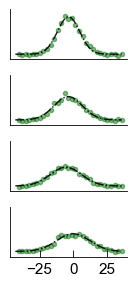

In [15]:
fig = plt.figure(figsize = (1.5, 3), tight_layout=True)
gs = gridspec.GridSpec(4, 1)

ax_profile = [fig.add_subplot(gs[0]),
              fig.add_subplot(gs[1]),
              fig.add_subplot(gs[2]),
              fig.add_subplot(gs[3])]

frames = np.arange(120,140, 5)

for count, i in enumerate(frames):

    im_labeled, n_labels = skimage.measure.label(im_m[i, :, :], background=0, return_num=True)
    im_props = skimage.measure.regionprops(im_labeled)

    area = []
    ind = []
    for L, prop in enumerate(im_props):
        ind = np.append(ind, L)
        area = np.append(area, prop.area)
    ind = np.argmax(area)

    im_labeled[im_labeled != ind + 1] = 0
    im_mask_ = im_labeled
 
    # quantify
    new_line = polygon_to_line(im_mask_)
    new_line_length_pixels = new_line.length
    vals = cell_contour_intensity_max(new_line,im[i,:,:].T)

    # Convert to real micron units 
    # Since I split the edge into 300 posiitons, 
    # need to convert to pixels and then to micron.
    x = np.arange(len(vals))*(new_line_length_pixels/300)/(995/210)

    if count ==0:
        y_zero_true_0 = np.mean(y[280:])

    y_zero_true = 0#np.mean(y[280:]) - y_zero_true_0
    y = vals
    y_zero = np.mean(y[280:])
    y_temp = y - y_zero
    
    # initial guesses for fit
    mean = x[150]
    sigma_ = 20*0.14 
    popt,pcov = curve_fit(gaus,x,
                           y_temp,
                          p0=[np.max(y_temp),mean,sigma_])

    ax_profile[count].plot(x-popt[1], gaus(x, *popt)+y_zero-y_zero_true, 
                           alpha = 0.9, color='k', zorder = 10, 
                           linestyle = 'dashdot', linewidth = 1)
    ax_profile[count].set_ylim(0,550)
    
    x_temp = x - popt[1]
    y_temp = vals-y_zero_true
    
    ax_profile[count].plot(x_temp[9::10], y_temp[9::10], 'o', 
                           alpha = 0.5, markersize = 3, 
                           zorder = 0, color = '#127514')
    
for ax_ in ax_profile[:-1]:
    ax_.set_xticks([])
    
for ax_ in ax_profile:
    ax_.set_yticks([])


# plt.savefig('../../figures/Figure5_D.pdf')

### Example fit and summary of D 

0.32589728094426107


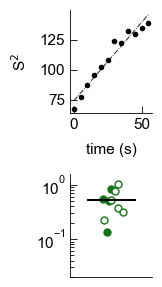

In [19]:
fig = plt.figure(figsize = (1.75, 3), tight_layout=True)
gs = gridspec.GridSpec(2, 1)

ax_D = fig.add_subplot(gs[1])
ax_S2 = fig.add_subplot(gs[0])

###########################
# Diff. Coef. values from analysis
###########################
D_untreat = [0.133, 0.508, 0.554, 0.835]
D_lat = [0.223, 0.371, 0.534 , 0.764, 1.029, 0.309]

ax_D.errorbar(x = [np.random.normal(0, 0.1) for val_ in np.arange(len(D_untreat))], 
              y = D_untreat,
            marker = 'o', markersize = 5, linewidth = 0, color = 'k',
            markerfacecolor='#127514', markeredgecolor='#127514', zorder = 1)

ax_D.errorbar(x = [np.random.normal(0, 0.1) for val_ in np.arange(len(D_lat))], 
              y = D_lat,
            marker = 'o', markersize = 5, linewidth = 0, color = 'k',
            markerfacecolor='white', markeredgecolor='#127514', zorder = 1)

ax_D.hlines(np.mean(np.append(D_untreat, D_lat)), -0.3,0.3, color = 'k', 
            linewidth = 1.5, zorder = 5)

ax_D.set_ylim(0.02,1.6)
ax_D.set_xlim(-0.5,0.5)
ax_D.set_yscale('log')
# ax_D.set_ylabel('diffusion\n'
#                 r'coefficient ($\mu$m$^{2}$/s)')

ax_D.set_xticklabels([])
ax_D.tick_params(axis='x', which='both', bottom=False, top=False)  
        
###########################

sigma_um = sigma[:12]#*0.1392
sigma_um2 = sigma_um**2
t = np.arange(5*len(sigma_um2), step = 5)

a = 0 
b = 20 
popt,pcov = curve_fit(linear,t,sigma_um2,p0=[a, b])


ax_S2.plot(t, sigma_um2, color = 'k', marker = 'o', markersize = 3,
              linewidth = 0)
ax_S2.plot(t, linear(t, *popt), color = 'k', linestyle = 'dashdot')

ax_S2.set_ylabel(r'S$^{2}$')

ax_S2.set_xlabel('time (s)')

# plt.savefig('../../figures/Figure5_D2.pdf')